## README


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and Functions

In [2]:
import os
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from skimage.metrics import structural_similarity as compute_ssim, peak_signal_noise_ratio as compute_psnr
from scipy.fftpack import fft2, fftshift

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gc
import sys
from skimage.color import rgb2gray
from skimage.transform import resize
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
import umap
from sklearn.decomposition import PCA

###########################################
# Helper function for dynamic printing
###########################################
def update_progress(msg):
    sys.stdout.write("\r" + " " * 130 + "\r")
    sys.stdout.write(msg)
    sys.stdout.flush()

###########################################
# Model Definition (same as before)
###########################################
class BrainMRIClassifier(nn.Module):
    def __init__(self):
        super(BrainMRIClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
        )
        self.flat_features = 256 * 9 * 9
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(self.flat_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def extract_features(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier[2](x)  # 512-dim features
            x = self.classifier[3](x)  # ReLU
        return x

###########################################
# Data Loading Functions (same as before)
###########################################
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def load_client_data(data_paths):
    clients_data = []
    for client in data_paths["clients"]:
        images = load_pickle_data(client["images"])
        labels = load_pickle_data(client["labels"])
        clients_data.append((images, labels))
    return clients_data

def load_test_data(data_paths):
    images = load_pickle_data(data_paths["test"]["images"])
    labels = load_pickle_data(data_paths["test"]["labels"])
    return images, labels

def load_inversion_images(folder_path):
    inversion_images = {}
    for root, dirs, files in os.walk(folder_path):
        dirs[:] = [d for d in dirs if not d.startswith('.ipynb_checkpoints')]
        for fname in files:
            if fname.endswith(".png"):
                img_path = os.path.join(root, fname)
                image = io.imread(img_path)
                if image.ndim == 3:
                    if image.shape[2] == 4:
                        image = image[..., :3]
                    image = rgb2gray(image)
                image = image.astype(np.float32)
                if image.max() > 1.0:
                    image /= image.max()
                if image.shape != (299, 299):
                    image = resize(image, (299, 299), anti_aliasing=True)
                rel_path = os.path.relpath(img_path, folder_path)
                inversion_images[rel_path] = image
    return inversion_images

###########################################
# Classification Functions
###########################################
def classify_image(model, image, device, confidence_threshold=0.9):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_img = transform(image).unsqueeze(0).to(device).float()
    with torch.no_grad():
        outputs = model(tensor_img)
        probabilities = torch.softmax(outputs, dim=1)
        max_prob, pred = torch.max(probabilities, dim=1)
    # Mark as uncertain if confidence is below threshold.
    if max_prob.item() < confidence_threshold:
        return -1, max_prob.item()
    return pred.item(), max_prob.item()

###########################################
# UMAP Projection Function
###########################################
def extract_features_from_image(model, image, device):
    model.eval()
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_img = transform(image).unsqueeze(0).to(device).float()
    with torch.no_grad():
        features = model.extract_features(tensor_img)
    return features.squeeze(0).cpu().numpy()

def compute_umap_projection(image_dict, model, device, apply_pca=False, n_components_pca=50, umap_params=None):
    features = []
    labels = []
    for key, image in image_dict.items():
        label = None
        for cls in [0, 1, 2, 3]:
            if f"class_{cls}" in key:
                label = cls
                break
        if label is None:
            continue
        feat = extract_features_from_image(model, image, device)
        features.append(feat)
        labels.append(label)
    features = np.array(features)
    if apply_pca:
        pca = PCA(n_components=n_components_pca)
        features = pca.fit_transform(features)
    if umap_params is None:
        umap_params = {'n_neighbors': 10, 'min_dist': 0.0, 'metric': 'cosine'}
    reducer = umap.UMAP(**umap_params)
    embedding = reducer.fit_transform(features)
    return embedding, labels



def store_inverted_global_performance(df_inv, subfolder_name):
    """
    Store the performance metrics of the global model from the inverted dataset.

    Args:
        df_inv: DataFrame containing the performance metrics
        subfolder_name: Name identifier for this run/dataset
    """
    # Extract global model performance only
    global_model_data = df_inv[df_inv['model_type'] == 'global'].copy()
    global_model_data['dataset_name'] = subfolder_name

    # Add to global storage
    global_inverted_performances.append(global_model_data)
    print(f"Stored inverted global model performance for dataset: {subfolder_name}")

def plot_global_inverted_performance(plot_type="line"):
    """
    Create a plot comparing global model performance across all stored runs.
    Call this function after all your runs are complete. Optimized for readability
    when scaled down to fit in a single column of a two-column document.

    Args:
        plot_type: String indicating the type of plot to create ("line" or "bar")
    """
    if not global_inverted_performances:
        print("No performance data available. Run store_inverted_global_performance first.")
        return

    # Set extremely large font sizes for all plot elements to ensure visibility when scaled down
    plt.rcParams.update({
        'font.size': 24,          # Base font size
        'axes.titlesize': 36,     # Title font size
        'axes.labelsize': 32,     # Axis label font size
        'xtick.labelsize': 30,    # X-tick label size
        'ytick.labelsize': 30,    # Y-tick label size
        'legend.fontsize': 28,    # Legend font size
        'legend.title_fontsize': 30  # Legend title font size
    })

    # Combine all dataframes
    combined_df = pd.concat(global_inverted_performances, ignore_index=True)

    if plot_type == "line":
        # Create the line plot
        plt.figure(figsize=(16, 12), dpi=300)  # Higher DPI for better scaling
        sns.set_style("whitegrid")

        # Use distinct colors, line styles, and markers
        colors = sns.color_palette("bright", n_colors=len(combined_df['dataset_name'].unique()))
        markers = ['o', 's', 'D', '^', 'v']

        # Line plot with classes on x-axis and datasets as different lines
        ax = sns.lineplot(
            data=combined_df,
            x="class_name",
            y="classification_accuracy",
            hue="dataset_name",
            style="dataset_name",
            markers=markers[:len(combined_df['dataset_name'].unique())],
            dashes=True,
            linewidth=6,           # Ultra thick lines
            markersize=24,         # Very large markers
            palette=colors
        )

        # Add random guess threshold line
        random_line = plt.axhline(y=0.25, color='red', linestyle='--', linewidth=4)

        # Enhance plot
        plt.title("Global Model Performance\nAcross Different Classes", fontsize=36, pad=30)
        plt.xlabel("Class", fontsize=32, labelpad=20)
        plt.ylabel("Accuracy", fontsize=32, labelpad=20)

        # Move legend outside and add random guess line
        handles, labels = ax.get_legend_handles_labels()
        handles.append(random_line)
        labels.append('Random Guess (0.25)')

        plt.legend(
            handles=handles,
            labels=labels,
            title="Dataset",
            title_fontsize=30,
            fontsize=28,
            loc='upper left',
            bbox_to_anchor=(1, 1),
            borderaxespad=1
        )

        # Y-axis limits set to 1.1 for full visibility
        plt.ylim(0, 1.1)

        # Additional formatting
        plt.grid(True, linestyle='-', linewidth=2.5, alpha=1)  # Bold, highly visible grid lines
        plt.tick_params(axis='both', which='major', pad=15, width=4, length=12)  # Extra prominent ticks

        # Ensure text has high contrast with white background in the saved version
        ax.set_facecolor('white')
        fig = plt.gcf()
        fig.patch.set_facecolor('white')

        plt.tight_layout()
        plt.savefig("global_model_inverted_performance_line.png", dpi=600, bbox_inches='tight')
        plt.savefig("global_model_inverted_performance_line.pdf", bbox_inches='tight')  # PDF for vector quality
        plt.show()

    elif plot_type == "bar":
        # Create a more column-friendly bar plot
        plt.figure(figsize=(14, 16), dpi=300)  # Taller than wide for better column fit
        sns.set_style("whitegrid")

        # Use distinct colors
        colors = sns.color_palette("bright", n_colors=len(combined_df['dataset_name'].unique()))

        # Grouped bar plot with classes on x-axis and datasets as groups
        ax = sns.barplot(
            data=combined_df,
            x="class_name",
            y="classification_accuracy",
            hue="dataset_name",
            palette=colors,
            errwidth=0,
            width=0.7  # Slightly narrower bars for better separation
        )

        # Add random guess threshold line (without adding to legend here)
        random_line = plt.axhline(y=0.25, color='red', linestyle='--', linewidth=4)

        # Enhance plot
        plt.title("Global Model Performance\nAcross Different Classes", fontsize=36, pad=30)
        plt.xlabel("Class", fontsize=32, labelpad=20)
        plt.ylabel("Accuracy", fontsize=32, labelpad=20)

        # Move legend outside and manually add random guess line to legend
        handles, labels = ax.get_legend_handles_labels()
        handles.append(random_line)
        labels.append('Random Guess (0.25)')

        # Remove the original legend and create a custom one
        ax.get_legend().remove()

        plt.legend(
            handles=handles,
            labels=labels,
            title="Dataset",
            title_fontsize=30,
            fontsize=28,
            loc='upper center',  # Place legend at the top for column layout
            bbox_to_anchor=(0.5, -0.15),  # Position below the plot
            borderaxespad=1,
            ncol=2  # Two columns for more compact legend
        )

        # Y-axis limits set to 1.1 for full visibility
        plt.ylim(0, 1.1)

        # Additional formatting
        plt.grid(True, linestyle='-', linewidth=2.5, alpha=1, axis='y')  # Bold, highly visible grid lines
        plt.tick_params(axis='both', which='major', pad=15, width=4, length=12)  # Extra prominent ticks

        # Ensure text has high contrast with white background in the saved version
        ax.set_facecolor('white')
        fig = plt.gcf()
        fig.patch.set_facecolor('white')

        plt.tight_layout()
        plt.savefig("global_model_inverted_performance_bar.png", dpi=600, bbox_inches='tight')
        plt.savefig("global_model_inverted_performance_bar.pdf", bbox_inches='tight')  # PDF for vector quality
        plt.show()

    else:
        print(f"Invalid plot type: {plot_type}. Use 'line' or 'bar'.")
        return

    # Print accuracy table for verification
    accuracy_table = pd.pivot_table(
        combined_df,
        values="classification_accuracy",
        index="dataset_name",
        columns="class_name",
        aggfunc="first"
    )
    print("\nAccuracy Values:")
    print(accuracy_table)

    # Reset matplotlib parameters to defaults
    plt.rcParams.update(plt.rcParamsDefault)

In [3]:
def run_comprehensive_evaluation(
    test_model_paths: dict,
    inverted_model_paths: dict,
    test_data_paths: dict,
    inversion_folder: str,
    subfolder_name: str,
    confidence_threshold: float = 0.9
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    subfolder_upper = subfolder_name.upper()
    base_out_dir = os.path.join("/content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox", subfolder_name)
    os.makedirs(base_out_dir, exist_ok=True)

    update_progress("Loading test dataset...\n")
    test_images, test_labels = load_test_data(test_data_paths)
    # Group test images by class; keys like "test_0", etc.
    test_by_class = {0: {}, 1: {}, 2: {}, 3: {}}
    for idx, (img, lbl) in enumerate(zip(test_images, test_labels)):
        test_by_class[lbl][f"test_{idx}"] = img

    update_progress("Loading inversion images...\n")
    inversion_images_all = load_inversion_images(inversion_folder)
    # Group inversion images by class using filename matching.
    inversion_by_class = {0: {}, 1: {}, 2: {}, 3: {}}
    for key, img in inversion_images_all.items():
        for cls in [0, 1, 2, 3]:
            if f"class_{cls}" in key:
                inversion_by_class[cls][key] = img
                break

    ###########################################
    # Load models for test evaluation
    ###########################################
    models_test = {}
    global_model_test = BrainMRIClassifier().to(device)
    global_model_test.load_state_dict(torch.load(test_model_paths['global'], map_location=device))
    global_model_test.eval()
    models_test['global'] = global_model_test
    for i, path in enumerate(test_model_paths['clients']):
        client_model = BrainMRIClassifier().to(device)
        client_model.load_state_dict(torch.load(path, map_location=device))
        client_model.eval()
        models_test[f'client_{i+1}'] = client_model

    ###########################################
    # Load models for inverted evaluation
    ###########################################
    models_inv = {}
    global_model_inv = BrainMRIClassifier().to(device)
    global_model_inv.load_state_dict(torch.load(inverted_model_paths['global'], map_location=device))
    global_model_inv.eval()
    models_inv['global'] = global_model_inv
    for i, path in enumerate(inverted_model_paths['clients']):
        client_model = BrainMRIClassifier().to(device)
        client_model.load_state_dict(torch.load(path, map_location=device))
        client_model.eval()
        models_inv[f'client_{i+1}'] = client_model

    # Initialize dictionaries to accumulate cumulative predictions.
    cumulative_preds_test = {model_key: {'true': [], 'pred': []} for model_key in models_test.keys()}
    cumulative_preds_inv  = {model_key: {'true': [], 'pred': []} for model_key in models_inv.keys()}

    aggregated_results_test = []
    aggregated_results_inv = []

    # Class names mapping
    class_names = {0: "Glioma", 1: "Meningioma", 2: "No Tumor", 3: "Pituitary"}

    # ---- Evaluate on the TEST dataset (aggregate over all classes) ----
    for model_key, model in models_test.items():
        true_all = []
        pred_all = []
        for cls in [0, 1, 2, 3]:
            for key, image in test_by_class[cls].items():
                pred, _ = classify_image(model, image, device, confidence_threshold)
                true_all.append(cls)
                pred_all.append(pred)
        cumulative_preds_test[model_key]['true'] = true_all
        cumulative_preds_test[model_key]['pred'] = pred_all

        cm = confusion_matrix(true_all, pred_all, labels=[0, 1, 2, 3])
        for i in [0, 1, 2, 3]:
            row_sum = np.sum(cm[i, :])
            acc = cm[i, i] / row_sum if row_sum > 0 else np.nan
            # Create binary vectors for class i (1 for class i, 0 otherwise)
            y_true_bin = [1 if t == i else 0 for t in true_all]
            y_pred_bin = [1 if p == i else 0 for p in pred_all]
            f1 = f1_score(y_true_bin, y_pred_bin, average='binary', pos_label=1) if row_sum > 0 else np.nan
            aggregated_results_test.append({
                "model_type": model_key,
                "class": i,
                "class_name": class_names[i],  # Add class_name field
                "classification_accuracy": acc,
                "f1_score": f1,
                "num_samples": row_sum
            })

    # ---- Evaluate on the INVERTED dataset (aggregate over all classes) ----
    for model_key, model in models_inv.items():
        true_all = []
        pred_all = []
        for cls in [0, 1, 2, 3]:
            for key, image in inversion_by_class[cls].items():
                pred, _ = classify_image(model, image, device, confidence_threshold)
                true_all.append(cls)
                pred_all.append(pred)
        cumulative_preds_inv[model_key]['true'] = true_all
        cumulative_preds_inv[model_key]['pred'] = pred_all

        cm = confusion_matrix(true_all, pred_all, labels=[0, 1, 2, 3])
        for i in [0, 1, 2, 3]:
            row_sum = np.sum(cm[i, :])
            acc = cm[i, i] / row_sum if row_sum > 0 else np.nan
            y_true_bin = [1 if t == i else 0 for t in true_all]
            y_pred_bin = [1 if p == i else 0 for p in pred_all]
            f1 = f1_score(y_true_bin, y_pred_bin, average='binary', pos_label=1) if row_sum > 0 else np.nan
            aggregated_results_inv.append({
                "model_type": model_key,
                "class": i,
                "class_name": class_names[i],  # Add class_name field
                "classification_accuracy": acc,
                "f1_score": f1,
                "num_samples": row_sum
            })

    # Save aggregated results as CSV files.
    df_test = pd.DataFrame(aggregated_results_test)
    df_inv = pd.DataFrame(aggregated_results_inv)
    test_csv = os.path.join(base_out_dir, f"{subfolder_name}_test_combined_results.csv")
    inv_csv  = os.path.join(base_out_dir, f"{subfolder_name}_inverted_combined_results.csv")
    df_test.to_csv(test_csv, index=False)
    df_inv.to_csv(inv_csv, index=False)
    update_progress(f"Aggregated CSV results saved to {test_csv} and {inv_csv}\n")

    # Store the global model performance for inverted data (this is new)
    store_inverted_global_performance(df_inv, subfolder_name)

    model_keys = list(models_test.keys())  # assumed same keys in both evaluations
    dataset_names = ["Test", "Inverted"]

    ###########################################
    # PLOT SET 1: Metrics plots - Individual plots instead of subplots
    # Separate plots for: Test Accuracy, Inverted Accuracy, Test F1, Inverted F1,
    # Test UMAP, Inverted UMAP
    ###########################################

    # Font and figure settings for better readability
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'figure.titlesize': 20
    })

    # Classification Accuracy - Test Data
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_test, x="class_name", y="classification_accuracy", hue="model_type", palette="Set2")
    plt.title(f"Classification Accuracy - Test Data ({subfolder_upper})")
    plt.xlabel("")  # No need for x-label as class names are self-explanatory
    plt.ylabel("Accuracy")
    plt.axhline(y=0.25, color='red', linestyle='--', label='Random (0.25)')
    plt.ylim(0, 1.05)  # Set y-axis limit with some padding
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Open grid for y-axis only
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    acc_test_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_accuracy_test.png")
    plt.savefig(acc_test_fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    update_progress(f"Test accuracy figure saved to {acc_test_fig_path}\n")

    # Classification Accuracy - Inverted Data
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_inv, x="class_name", y="classification_accuracy", hue="model_type", palette="Set2")
    plt.title(f"Classification Accuracy - Inverted Data ({subfolder_upper})")
    plt.xlabel("")  # No need for x-label as class names are self-explanatory
    plt.ylabel("Accuracy")
    plt.axhline(y=0.25, color='red', linestyle='--', label='Random (0.25)')
    plt.ylim(0, 1.05)  # Set y-axis limit with some padding
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Open grid for y-axis only
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    acc_inv_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_accuracy_inverted.png")
    plt.savefig(acc_inv_fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    update_progress(f"Inverted accuracy figure saved to {acc_inv_fig_path}\n")

    # F1 Scores - Test Data
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_test, x="class_name", y="f1_score", hue="model_type", palette="Set1")
    plt.title(f"F1 Scores - Test Data ({subfolder_upper})")
    plt.xlabel("")  # No need for x-label as class names are self-explanatory
    plt.ylabel("F1 Score")
    plt.axhline(y=0.25, color='red', linestyle='--', label='Random (0.25)')
    plt.ylim(0, 1.05)  # Set y-axis limit with some padding
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Open grid for y-axis only
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    f1_test_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_f1_test.png")
    plt.savefig(f1_test_fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    update_progress(f"Test F1 figure saved to {f1_test_fig_path}\n")

    # F1 Scores - Inverted Data
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_inv, x="class_name", y="f1_score", hue="model_type", palette="Set1")
    plt.title(f"F1 Scores - Inverted Data ({subfolder_upper})")
    plt.xlabel("")  # No need for x-label as class names are self-explanatory
    plt.ylabel("F1 Score")
    plt.axhline(y=0.25, color='red', linestyle='--', label='Random (0.25)')
    plt.ylim(0, 1.05)  # Set y-axis limit with some padding
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Open grid for y-axis only
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    f1_inv_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_f1_inverted.png")
    plt.savefig(f1_inv_fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    update_progress(f"Inverted F1 figure saved to {f1_inv_fig_path}\n")

    # UMAP Projections - Test Data
    test_umap_dict = {}
    for cls in [0,1,2,3]:
        for key, img in test_by_class[cls].items():
            test_umap_dict[f"{key}_class_{cls}"] = img

    plt.figure(figsize=(12, 10))
    embedding_test, labels_test = compute_umap_projection(test_umap_dict, models_test['global'], device)

    # Create a mapping from numerical labels to class names for the scatter plot
    label_names = [class_names[label] for label in labels_test]
    unique_labels = np.unique(labels_test)

    # Create a custom colormap with discrete colors
    cmap = plt.cm.get_cmap('viridis', len(unique_labels))

    # Plot each class with a different color and label
    for i, label in enumerate(unique_labels):
        mask = np.array(labels_test) == label
        plt.scatter(embedding_test[mask, 0], embedding_test[mask, 1],
                   c=[cmap(i)], label=class_names[label], alpha=0.7, s=80)

    plt.title(f"UMAP Projection - Test Data ({subfolder_upper})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Class")
    plt.grid(linestyle='--', alpha=0.4)
    plt.tight_layout()
    umap_test_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_umap_test.png")
    plt.savefig(umap_test_fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    update_progress(f"Test UMAP figure saved to {umap_test_fig_path}\n")

    # UMAP Projections - Inverted Data
    plt.figure(figsize=(12, 10))
    embedding_inv, labels_inv = compute_umap_projection(inversion_images_all, models_inv['global'], device)

    # Create a mapping from numerical labels to class names for the scatter plot
    unique_labels_inv = np.unique(labels_inv)

    # Plot each class with a different color and label
    for i, label in enumerate(unique_labels_inv):
        mask = np.array(labels_inv) == label
        plt.scatter(embedding_inv[mask, 0], embedding_inv[mask, 1],
                   c=[cmap(i)], label=class_names[label], alpha=0.7, s=80)

    plt.title(f"UMAP Projection - Inverted Data ({subfolder_upper})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title="Class")
    plt.grid(linestyle='--', alpha=0.4)
    plt.tight_layout()
    umap_inv_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_umap_inverted.png")
    plt.savefig(umap_inv_fig_path, dpi=300, bbox_inches='tight')
    plt.close()
    update_progress(f"Inverted UMAP figure saved to {umap_inv_fig_path}\n")

    ###########################################
    # PLOT SET 2: Confusion Matrices - Separate plots for each model and dataset
    ###########################################
    for model_key in model_keys:
        # Test Data Confusion Matrix
        plt.figure(figsize=(10, 8))
        true_labels = cumulative_preds_test[model_key]['true']
        pred_labels = cumulative_preds_test[model_key]['pred']
        cm = confusion_matrix(true_labels, pred_labels, labels=[0,1,2,3])

        # Use class names instead of numbers
        labels = [class_names[i] for i in range(4)]

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=labels,
                   yticklabels=labels,
                   annot_kws={"size": 14})
        plt.title(f"Confusion Matrix - {model_key.capitalize()} Model\nTest Data ({subfolder_upper})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        conf_test_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_confusion_matrix_{model_key}_test.png")
        plt.savefig(conf_test_fig_path, dpi=300, bbox_inches='tight')
        plt.close()
        update_progress(f"Test confusion matrix for {model_key} saved to {conf_test_fig_path}\n")

        # Inverted Data Confusion Matrix
        plt.figure(figsize=(10, 8))
        true_labels = cumulative_preds_inv[model_key]['true']
        pred_labels = cumulative_preds_inv[model_key]['pred']
        cm = confusion_matrix(true_labels, pred_labels, labels=[0,1,2,3])

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=labels,
                   yticklabels=labels,
                   annot_kws={"size": 14})
        plt.title(f"Confusion Matrix - {model_key.capitalize()} Model\nInverted Data ({subfolder_upper})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        conf_inv_fig_path = os.path.join(base_out_dir, f"{subfolder_name}_confusion_matrix_{model_key}_inverted.png")
        plt.savefig(conf_inv_fig_path, dpi=300, bbox_inches='tight')
        plt.close()
        update_progress(f"Inverted confusion matrix for {model_key} saved to {conf_inv_fig_path}\n")

    # Cleanup models
    for m in list(models_test.values()) + list(models_inv.values()):
        del m
    gc.collect()
    torch.cuda.empty_cache()

# Main Execution Loop

In [4]:
global_inverted_performances = []

In [5]:
###########################################
# Example usage:
###########################################
if __name__ == "__main__":
    # These dictionaries must be provided by the user.
    # Each should have a 'global' key and a 'clients' list.
    test_model_paths = { ## This is where you pass the models you want to test for privacy
        'global': '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/global_model.pth',  ## <- Replace this
        'clients': [
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_0_model.pth',  ## <- Replace this
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_1_model.pth',  ## <- Replace this
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_2_model.pth'   ## <- Replace this
        ]
    }
    bench_model_paths = { ## This is where you pass the bench models for comparison purposes
        'global': '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/global_model.pth',  ## <- Replace this
        'clients': [
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_0_model.pth',  ## <- Replace this
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_1_model.pth',  ## <- Replace this
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_2_model.pth'   ## <- Replace this
        ]
    }
    # Data paths for test dataset
    DATA_PATHS = { ## This is where you pass the test dataset corresponding to the test model variant
                   ## For exmaple, to test the bench model you pas the bench data, for gs 20% please pass for gs20p data
                   ## or simply run the cell below!
        "test": {
            "images": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/test_images.pickle",  ## <- Replace this
            "labels": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/test_labels.pickle"  ## <- Replace this
        }
    }
    ## Inversion folder is where you read the inverted images from the blackbox model inversion attack!
    inversion_folder = "/content/drive/MyDrive/Spring 25/github_brainfl/Model_Inversion/blackbox/inverted_images/bench"  ## <- Replace this
    subfolder_name = "bench"  # example subfolder name to save the results

    run_comprehensive_evaluation(test_model_paths, bench_model_paths, DATA_PATHS, inversion_folder, subfolder_name)

Loading test dataset...
Loading inversion images...


<ipython-input-3-bf098bc70cd0>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model_test.load_state_dict(torch.load(test_model_paths['global'], map_location=device

Aggregated CSV results saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_test_combined_results.csv and /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_inverted_combined_results.csv
Stored inverted global model performance for dataset: bench
Test accuracy figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_accuracy_test.png
Inverted accuracy figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_accuracy_inverted.png
Test F1 figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_f1_test.png
Inverted F1 figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_f1_inverted.png


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-3-bf098bc70cd0>:236: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


Test UMAP figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_umap_test.png


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Inverted UMAP figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_umap_inverted.png
Test confusion matrix for global saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_confusion_matrix_global_test.png
Inverted confusion matrix for global saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_confusion_matrix_global_inverted.png
Test confusion matrix for client_1 saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_confusion_matrix_client_1_test.png
Inverted confusion matrix for client_1 saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_confusion_matrix_client_1_inverted.png
Test confusion matrix for client_2 saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/bench/bench_confusion_matrix_client_2_

In [6]:
###########################################
# Example usage:
###########################################
if __name__ == "__main__":
    # These dictionaries must be provided by the user.
    # Each should have a 'global' key and a 'clients' list.
    test_model_paths = {
        'global': '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/global_model_gs20p.pth',
        'clients': [
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_0_model_gs20p.pth',
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_1_model_gs20p.pth',
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_2_model_gs20p.pth'
        ]
    }
    bench_model_paths = {
        'global': '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/global_model.pth',
        'clients': [
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_0_model.pth',
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_1_model.pth',
            '/content/drive/MyDrive/Spring 25/github_brainfl/pretrained_models/client_2_model.pth'
        ]
    }
    # Data paths for test dataset
    DATA_PATHS = {
        "test": {
            "images": "/content/drive/MyDrive/Spring 25/github_brainfl/data/gs/test_images_gs20p.pickle",
            "labels": "/content/drive/MyDrive/Spring 25/github_brainfl/data/bench/test_labels.pickle"
        }
    }
    inversion_folder = "/content/drive/MyDrive/Spring 25/github_brainfl/Model_Inversion/blackbox/inverted_images/gs20p"
    subfolder_name = "gs20p"  # example subfolder name

    run_comprehensive_evaluation(test_model_paths, bench_model_paths, DATA_PATHS, inversion_folder, subfolder_name)

Loading test dataset...
Loading inversion images...


<ipython-input-3-bf098bc70cd0>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model_test.load_state_dict(torch.load(test_model_paths['global'], map_location=device

Aggregated CSV results saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_test_combined_results.csv and /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_inverted_combined_results.csv
Stored inverted global model performance for dataset: gs20p
Test accuracy figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_accuracy_test.png
Inverted accuracy figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_accuracy_inverted.png
Test F1 figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_f1_test.png
Inverted F1 figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_f1_inverted.png


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
<ipython-input-3-bf098bc70cd0>:236: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


Test UMAP figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_umap_test.png


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Inverted UMAP figure saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_umap_inverted.png
Test confusion matrix for global saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_confusion_matrix_global_test.png
Inverted confusion matrix for global saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_confusion_matrix_global_inverted.png
Test confusion matrix for client_1 saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_confusion_matrix_client_1_test.png
Inverted confusion matrix for client_1 saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_confusion_matrix_client_1_inverted.png
Test confusion matrix for client_2 saved to /content/drive/MyDrive/Spring 25/github_brainfl/results/model_inversion_blackbox/gs20p/gs20p_confusion_matrix_client_2_

<ipython-input-2-918119d39e10>:296: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(


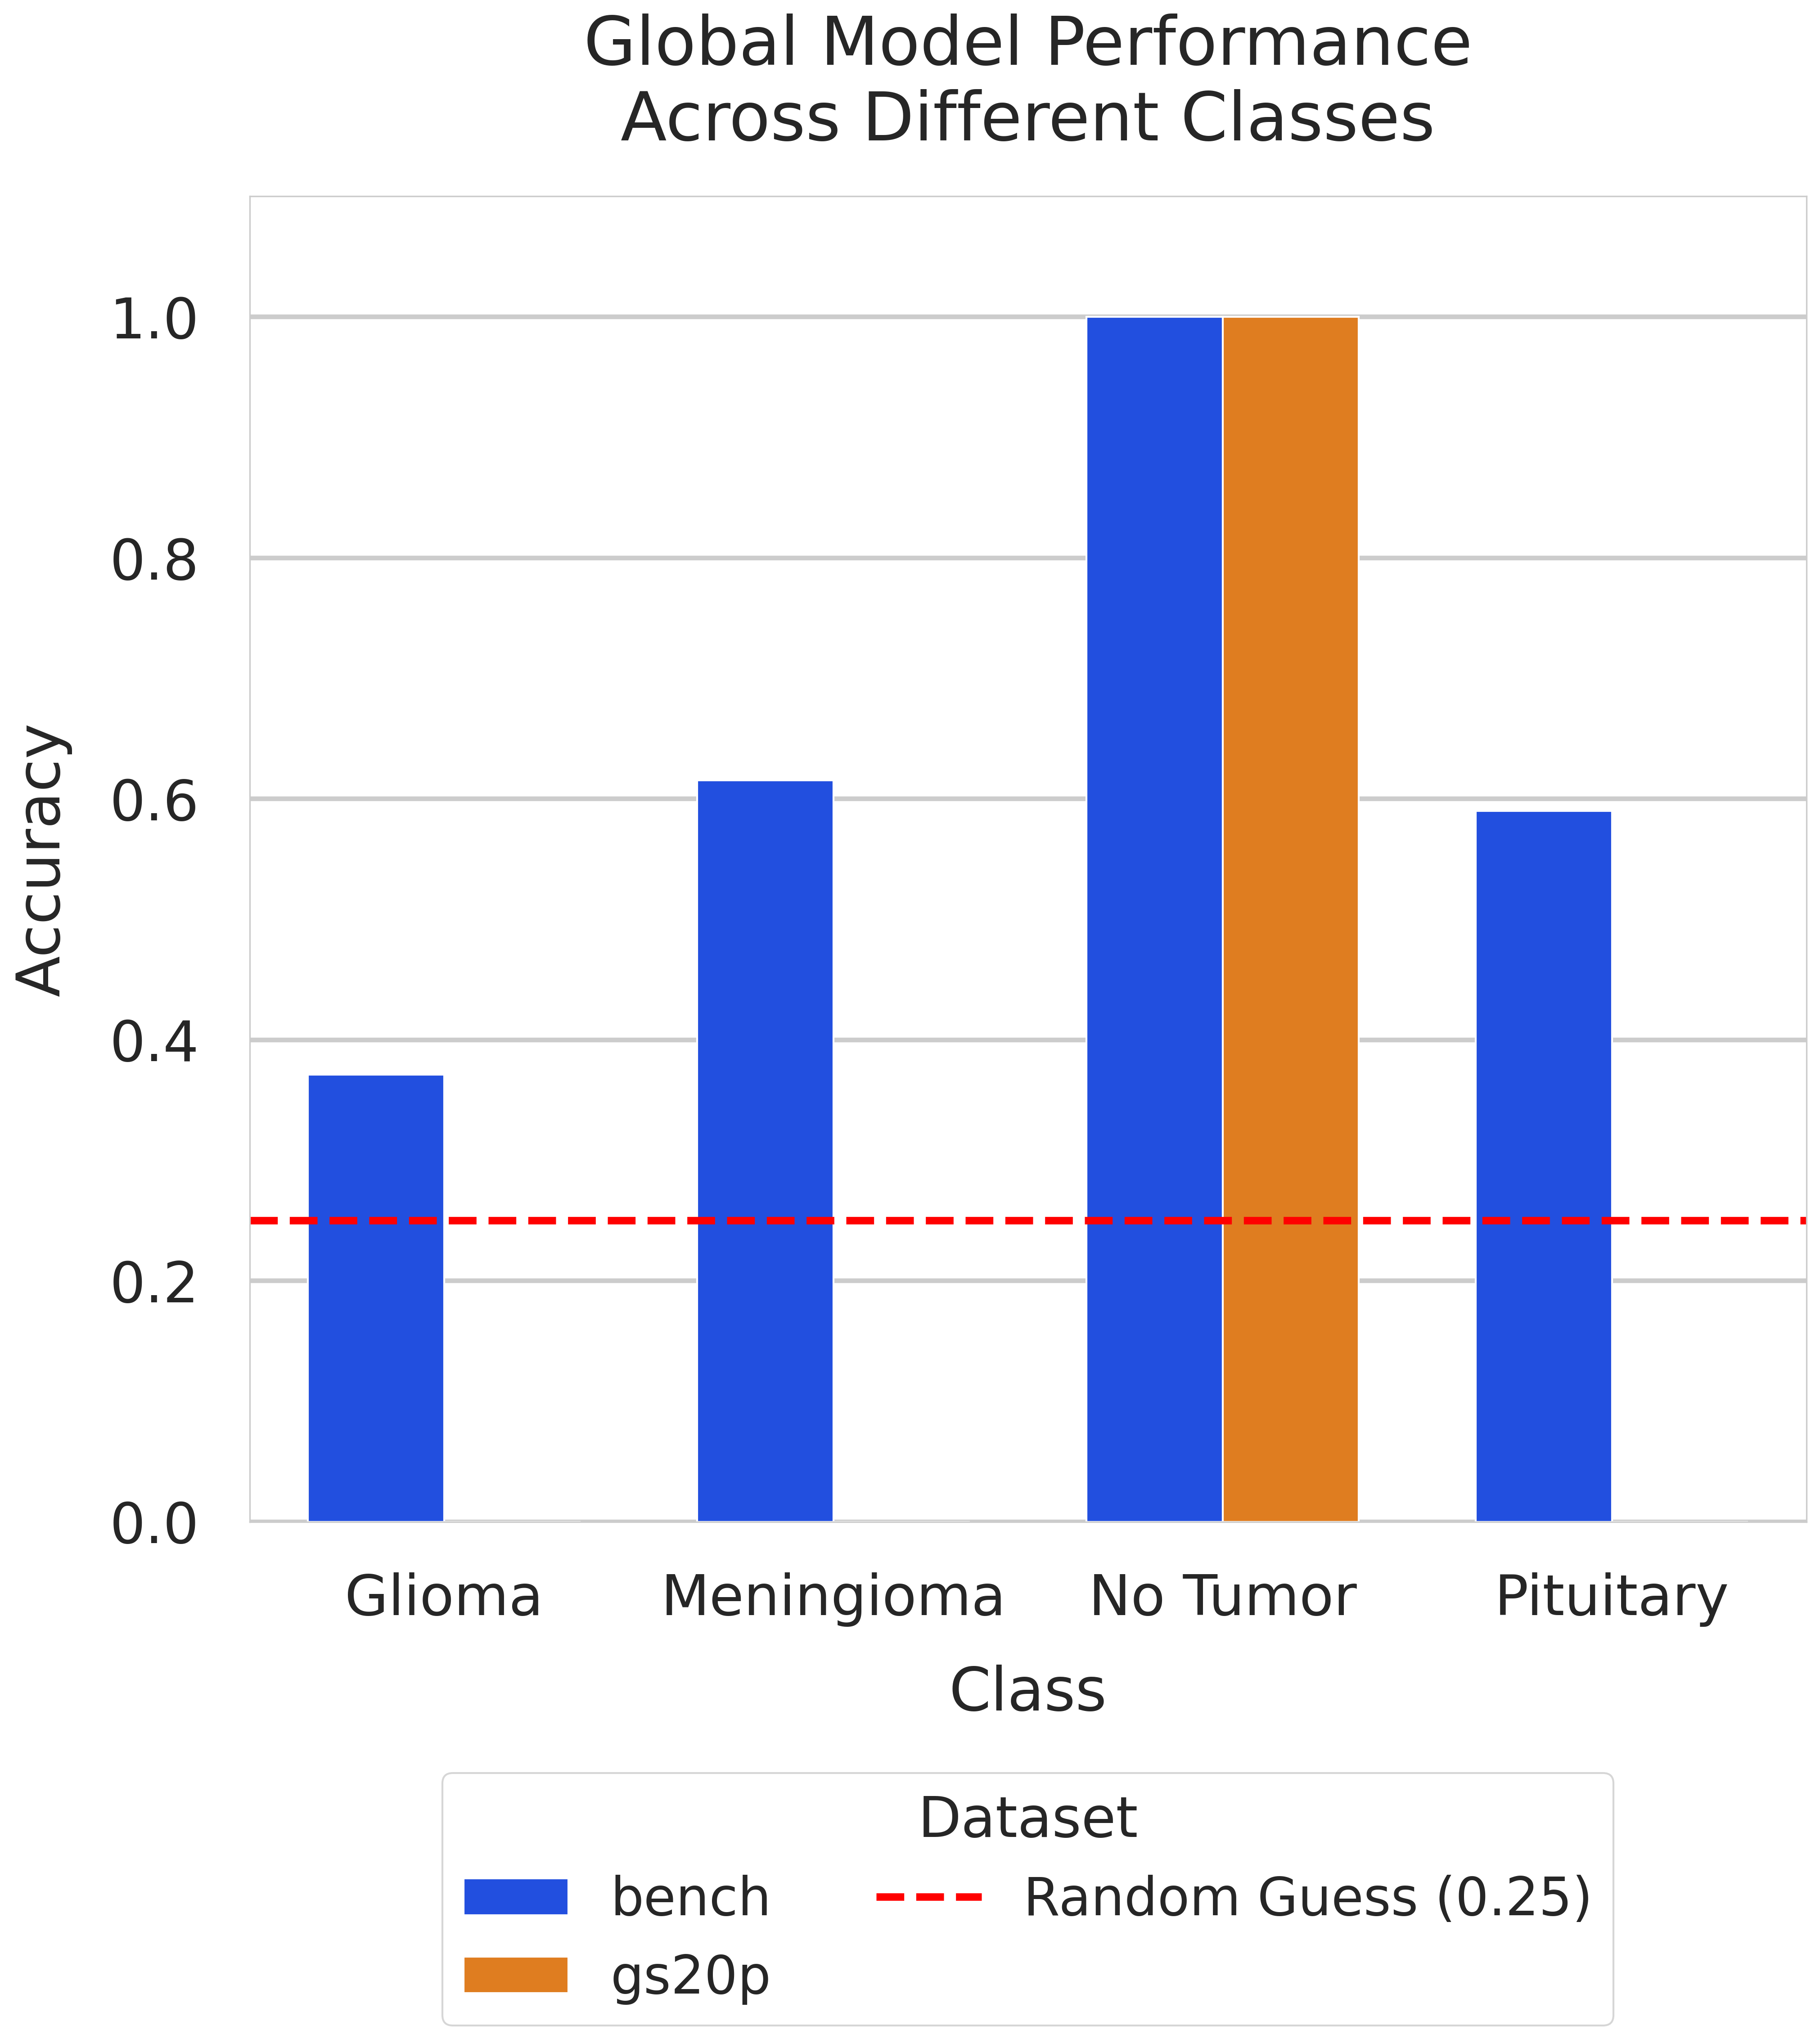


Accuracy Values:
class_name      Glioma  Meningioma  No Tumor  Pituitary
dataset_name                                           
bench         0.371134    0.615385       1.0       0.59
gs20p         0.000000    0.000000       1.0       0.00


In [7]:
plot_global_inverted_performance(plot_type="bar")